In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 1. Predicting temperature

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

weather = pd.read_sql_query('select * from weatherinszeged',con=engine)

engine.dispose()

weather.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [3]:
# Creating the regression Model

X = weather[['humidity', 'windspeed', 'windbearing', 'pressure']]
Y = weather['temperature']

from sklearn.linear_model import LinearRegression

lrm = LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-3.24962454e+01 -2.01413742e-01  4.04836936e-03 -6.91759209e-04]

Intercept: 
 37.92643818528538


### Assumption one: linearity of the model in its coefficients
In principle, this assumption is not related to estimation but to how we specify our model. So as long as we use models that take into account this linearity assumption as we did in our medical costs example, then we shouldn't worry about this assumption at all.

### Assumption two: the error term should be zero on average

In [4]:
pred = lrm.predict(X)
errors = Y - pred

print('The mean of errors for regression model is {}'.format(np.mean(errors)))

The mean of errors for regression model is -4.714704061941714e-16


### Assumption three: homoscedasticity

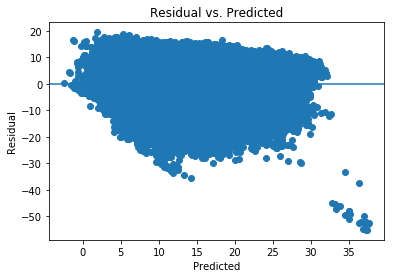

In [5]:
plt.scatter(pred, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [13]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(pred, errors)
lev_stats = levene(pred, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2464.84 and p value is 0
Levene test statistic value is 2321.24 and p value is 0


### Assumption four: low multicollinearity

In [7]:
X.corr()

,humidity,windspeed,windbearing,pressure
humidity,1.000000,-0.224951,0.000735,0.005454
windspeed,-0.224951,1.000000,0.103822,-0.049263
windbearing,0.000735,0.103822,1.000000,-0.011651
pressure,0.005454,-0.049263,-0.011651,1.000000


### Assumption five: error terms should be uncorrelated with one another

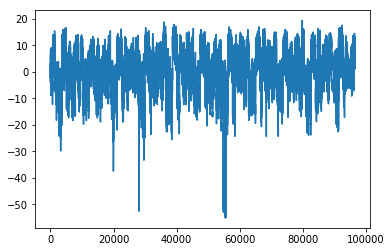

In [8]:
plt.plot(errors)

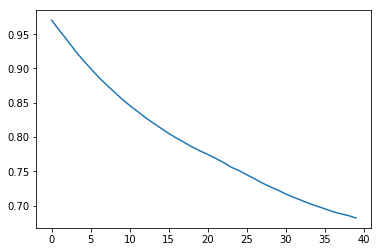

In [9]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

### Assumption six: features shouldn't be correlated with the errors

In [11]:
weather['errors'] = errors
weather.corr()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,errors
temperature,1.000000,0.992629,-6.322547e-01,8.956968e-03,2.998820e-02,0.392847,NaN,-5.447106e-03,7.611978e-01
apparenttemperature,0.992629,1.000000,-6.025710e-01,-5.664970e-02,2.903052e-02,0.381718,NaN,-2.189998e-04,7.649979e-01
humidity,-0.632255,-0.602571,1.000000e+00,-2.249515e-01,7.346454e-04,-0.369173,NaN,5.454263e-03,-1.935763e-16
windspeed,0.008957,-0.056650,-2.249515e-01,1.000000e+00,1.038215e-01,0.100749,NaN,-4.926281e-02,-3.912914e-17
windbearing,0.029988,0.029031,7.346454e-04,1.038215e-01,1.000000e+00,0.047594,NaN,-1.165088e-02,-2.293671e-16
visibility,0.392847,0.381718,-3.691725e-01,1.007493e-01,4.759418e-02,1.000000,NaN,5.981838e-02,2.106702e-01
loudcover,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pressure,-0.005447,-0.000219,5.454263e-03,-4.926281e-02,-1.165088e-02,0.059818,NaN,1.000000e+00,-7.998021e-16
errors,0.761198,0.764998,-1.935763e-16,-3.912914e-17,-2.293671e-16,0.210670,NaN,-7.998021e-16,1.000000e+00


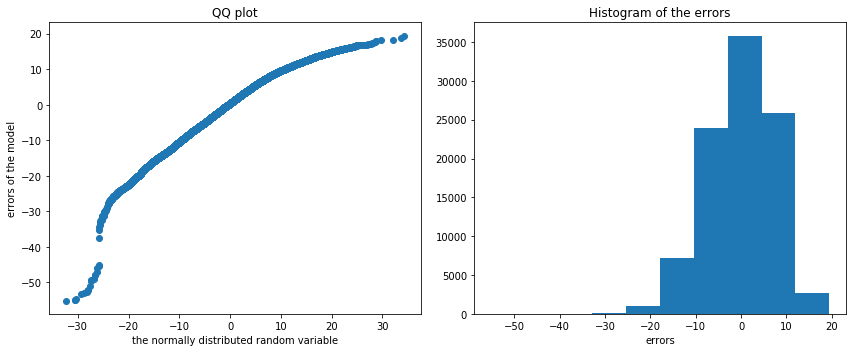

In [10]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [15]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

In [16]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3793.296735252357 and p value is 0.0
Normality test statistics is 3375.4323076995743 and p value is 0.0


The p-values of both tests indicate that our errors are not normally distributed.

## 2. House prices

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [18]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house_df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

house_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [19]:
numeric = house_df.select_dtypes(['int64', 'float64']).columns
print('The numner of numeric columns is {}'.format(len(numeric)))

for i in numeric:
    house_df[i] = house_df[i].fillna(house_df[i].mean())
    
non_numeric = house_df.select_dtypes('object').columns

# Now we concerrt our non numeric data to numeric values

house_df = pd.concat([house_df,pd.get_dummies(house_df.salecondition, prefix="salecondition", drop_first=True)], axis=1)
house_df = pd.concat([house_df,pd.get_dummies(house_df.street, prefix="street", drop_first=True)], axis=1)

dummy_columns = list(pd.get_dummies(house_df.salecondition, prefix="salecondition", drop_first=True).columns)
dummy_columns = dummy_columns + list(pd.get_dummies(house_df.street, prefix="street", drop_first=True).columns)

from sklearn.linear_model import LinearRegression

# Creating the model

X = house_df[['overallqual', 'grlivarea', 'garagecars','garagearea', 'totalbsmtsf'] + dummy_columns]
Y = house_df['saleprice']

lrm = LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)

The numner of numeric columns is 38

Coefficients: 
 [ 2.21944470e+04  4.67520908e+01  1.43684254e+04  1.23629987e+01
  3.05503178e+01  1.98172472e+04  9.55421048e+03 -1.17788463e+04
  1.13866938e+04  3.39316841e+04  8.91805115e+03]

Intercept: 
 -109945.17052537345


### Assumption one: linearity of the model in its coefficients

In principle, this assumption is not related to estimation but to how we specify our model. So as long as we use models that take into account this linearity assumption as we did in our medical costs example, then we shouldn't worry about this assumption at all.

### Assumption two: the error term should be zero on average

In [20]:
pred = lrm.predict(X)
errors = Y - pred

print('The mean of errors for regression model is {}'.format(np.mean(errors)))

The mean of errors for regression model is 8.531807832521936e-12


##### The average of error is really small.

### Assumption three: homoscedasticity

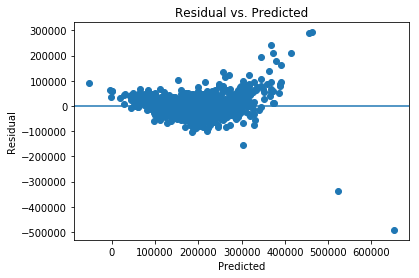

In [21]:
plt.scatter(pred, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [22]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(pred, errors)
lev_stats = levene(pred, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 500.411 and p value is 7.74e-111
Levene test statistic value is 462.321 and p value is 2.57e-95


### Assumption four: low multicollinearity

In [23]:
X.corr()

,overallqual,grlivarea,garagecars,garagearea,totalbsmtsf,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial,street_Pave
overallqual,1.000000,0.593007,0.600671,0.562022,0.537808,-0.041677,-0.044950,-0.025515,-0.143282,0.323295,0.058823
grlivarea,0.593007,1.000000,0.467247,0.468997,0.454868,-0.040208,0.032283,-0.007743,-0.091572,0.163239,0.044121
garagecars,0.600671,0.467247,1.000000,0.882475,0.434585,-0.106443,0.028378,-0.010589,-0.121886,0.282164,-0.020025
garagearea,0.562022,0.468997,0.882475,1.000000,0.486665,-0.101277,-0.005458,-0.016173,-0.130874,0.294714,-0.047794
totalbsmtsf,0.537808,0.454868,0.434585,0.486665,1.000000,-0.055895,-0.047002,0.019569,-0.160222,0.266268,0.005068
salecondition_AdjLand,-0.041677,-0.040208,-0.106443,-0.101277,-0.055895,1.000000,-0.004772,-0.006177,-0.112080,-0.016038,0.003367
salecondition_Alloca,-0.044950,0.032283,0.028378,-0.005458,-0.047002,-0.004772,1.000000,-0.010729,-0.194663,-0.027856,-0.112734
salecondition_Family,-0.025515,-0.007743,-0.010589,-0.016173,0.019569,-0.006177,-0.010729,1.000000,-0.252006,-0.036062,0.007571
salecondition_Normal,-0.143282,-0.091572,-0.121886,-0.130874,-0.160222,-0.112080,-0.194663,-0.252006,1.000000,-0.654323,-0.002140
salecondition_Partial,0.323295,0.163239,0.282164,0.294714,0.266268,-0.016038,-0.027856,-0.036062,-0.654323,1.000000,0.019657


### Assumption five: error terms should be uncorrelated with one another

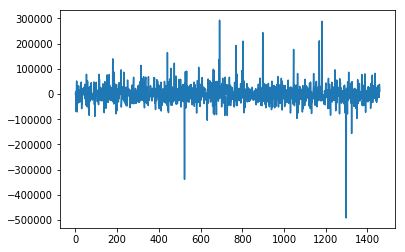

In [24]:
plt.plot(errors)

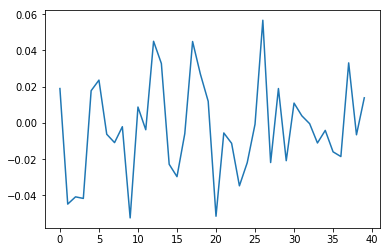

In [25]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

### Assumption six: features shouldn't be correlated with the errors

In [26]:
house_df['errors'] = errors
house_df.corr()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,mosold,yrsold,saleprice,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial,street_Pave,errors
id,1.000000,0.011156,-0.009601,-0.033226,-2.836475e-02,0.012609,-0.012713,-0.021998,-0.050199,-0.005024,...,0.021172,0.000712,-0.021917,-3.485241e-02,-9.017802e-03,4.865426e-03,1.588145e-02,-2.073821e-02,8.916351e-03,-2.408325e-02
mssubclass,0.011156,1.000000,-0.357056,-0.139781,3.262771e-02,-0.059316,0.027850,0.040581,0.022895,-0.069836,...,-0.013585,-0.021407,-0.084284,1.624105e-02,3.000194e-02,9.830841e-04,2.435910e-02,-5.106850e-02,-2.496859e-02,-1.388552e-01
lotfrontage,-0.009601,-0.357056,1.000000,0.306795,2.341962e-01,-0.052820,0.117598,0.082746,0.179283,0.215828,...,0.010158,0.006768,0.334901,-3.701951e-02,-1.808977e-02,1.581790e-02,-7.207418e-02,1.248421e-01,-3.732277e-02,2.545396e-02
lotarea,-0.033226,-0.139781,0.306795,1.000000,1.058057e-01,-0.005636,0.014228,0.013788,0.103960,0.214103,...,0.001205,-0.014261,0.263843,-1.320792e-02,8.966334e-03,-1.078108e-02,5.711388e-03,2.263539e-02,-1.971309e-01,1.435801e-01
overallqual,-0.028365,0.032628,0.234196,0.105806,1.000000e+00,-0.091932,0.572323,0.550684,0.410238,0.239666,...,0.070815,-0.027347,0.790982,-4.167726e-02,-4.495015e-02,-2.551467e-02,-1.432819e-01,3.232947e-01,5.882319e-02,2.301449e-14
overallcond,0.012609,-0.059316,-0.052820,-0.005636,-9.193234e-02,1.000000,-0.375983,0.073741,-0.127788,-0.046231,...,-0.003511,0.043950,-0.077856,-3.888798e-02,-3.344392e-02,-2.387309e-02,1.616418e-01,-1.516588e-01,4.284840e-02,1.056139e-01
yearbuilt,-0.012713,0.027850,0.117598,0.014228,5.723228e-01,-0.375983,1.000000,0.592855,0.314745,0.249503,...,0.012398,-0.013618,0.522897,-4.560088e-02,-1.010414e-02,-3.578486e-02,-1.584269e-01,3.438954e-01,2.113676e-02,1.105631e-01
yearremodadd,-0.021998,0.040581,0.082746,0.013788,5.506839e-01,0.073741,0.592855,1.000000,0.179186,0.128451,...,0.021490,0.035743,0.507101,-4.029353e-02,-2.072741e-02,-4.805649e-02,-1.205765e-01,3.228367e-01,6.546482e-02,1.137656e-01
masvnrarea,-0.050199,0.022895,0.179283,0.103960,4.102377e-01,-0.127788,0.314745,0.179186,1.000000,0.263582,...,-0.005940,-0.008184,0.475241,-1.195904e-02,-9.688861e-03,-9.914284e-03,-8.424133e-02,1.656056e-01,1.732592e-02,1.213169e-01
bsmtfinsf1,-0.005024,-0.069836,0.215828,0.214103,2.396660e-01,-0.046231,0.249503,0.128451,0.263582,1.000000,...,-0.015727,0.014359,0.386420,-1.487441e-02,2.136928e-02,7.651669e-04,-1.955996e-02,4.491202e-02,-1.564272e-02,2.018947e-01


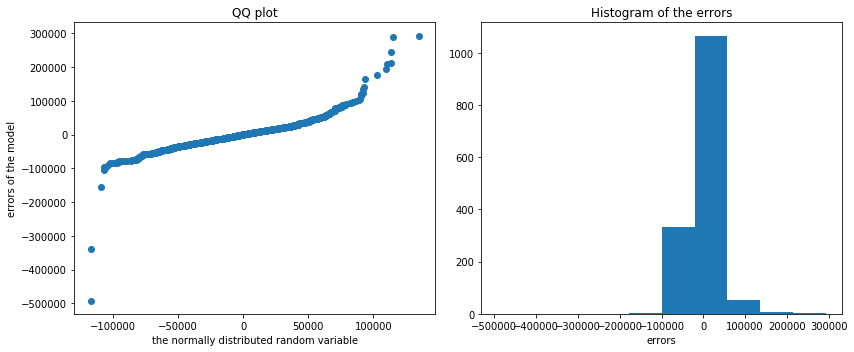

In [27]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [28]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 55641.99924359326 and p value is 0.0
Normality test statistics is 512.4202014271902 and p value is 5.362496876258107e-112


The p-values of both tests indicate that our errors are not normally distributed.